In [84]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from keras.callbacks import LearningRateScheduler
from keras.utils import to_categorical

Here we have semantic (or class) segmentation: we paint each front door as dark green, even if we have 5 or just 1 in the image (as opposed to instance segmentation, where we would assign a different color to each front door object/instance)

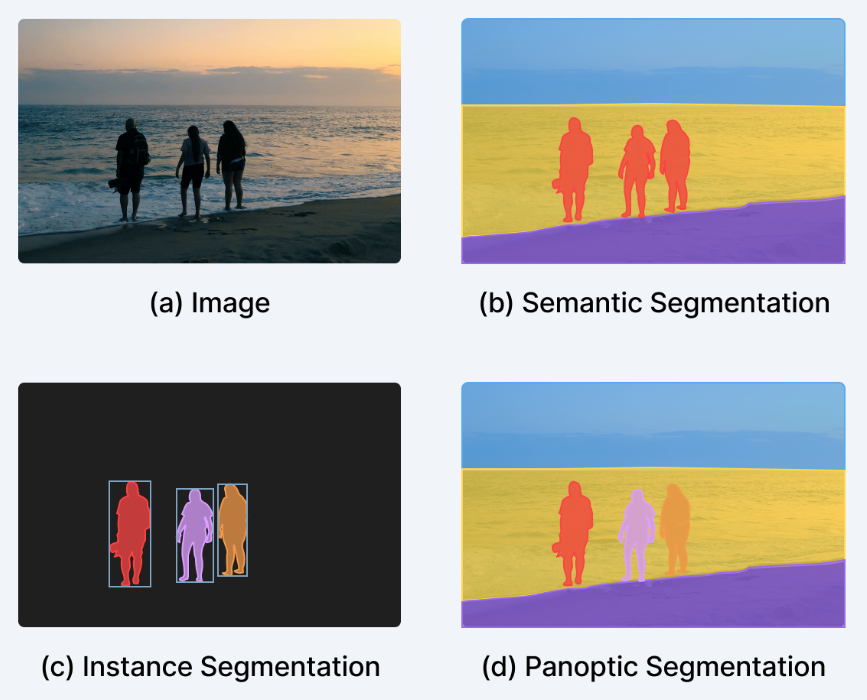

Useful links & resources:

- https://towardsdatascience.com/efficient-image-segmentation-using-pytorch-part-1-89e8297a0923
- https://www.tensorflow.org/tutorials/images/segmentation
- https://github.com/sheikhazhanmohammed/sadma
- https://www.kaggle.com/code/yassinealouini/all-the-segmentation-metrics
- https://github.com/milesial/Pytorch-UNet
- https://github.com/asanakoy/kaggle_carvana_segmentation/tree/master

Pretrained models:

- https://pytorch.org/serve/model_zoo.html
- https://pytorch.org/vision/stable/models.html#object-detection-instance-segmentation-and-person-keypoint-detection

In [85]:
# Image names in all folders are of the form XXXX.png (ex: 0001.png)

IMAGES_FOLDER = './carseg_data/images/'
BLACK_CAR_FOLDER = 'black_5_doors/'
ORANGE_CAR_FOLDER = 'orange_3_doors/'
REAL_CAR_FOLDER = 'photo/'
SEGMENTATION_FOLDER = 'with_segmentation/'
NO_SEGMENTATION_FOLDER = 'no_segmentation/'

torch.Size([3, 360, 640]) tensor(255, dtype=torch.uint8)


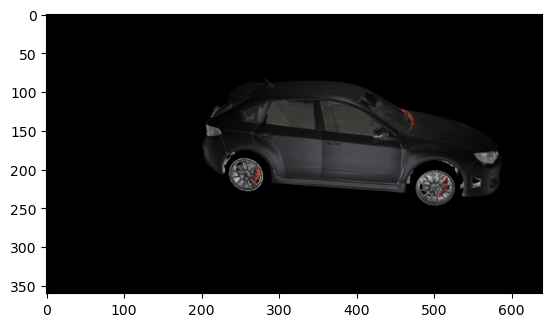

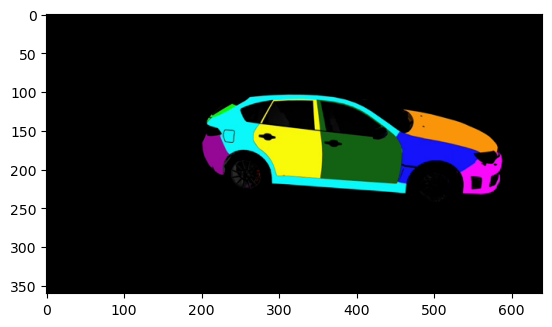

In [86]:
# Read images and see examples
IMAGE_PATH = '/0001.png'

image_original = torchvision.io.read_image(IMAGES_FOLDER + BLACK_CAR_FOLDER + NO_SEGMENTATION_FOLDER + IMAGE_PATH)
image_segmented = torchvision.io.read_image(IMAGES_FOLDER + BLACK_CAR_FOLDER + SEGMENTATION_FOLDER + IMAGE_PATH)

print(image_original.shape, image_original.max())

plt.imshow(image_original.permute(1, 2, 0))
plt.show()
plt.imshow(image_segmented.permute(1, 2, 0))
plt.show()

In [87]:
# The shapes of all 3 categories of images, different across folders but consisten inside itself
# Also the maximum in all images is 255, so scaling all images by dividing with 255 would be appropriate

BLACK_DIR_ORIGINAL = IMAGES_FOLDER + BLACK_CAR_FOLDER + NO_SEGMENTATION_FOLDER
ORANGE_DIR_ORIGINAL = IMAGES_FOLDER + ORANGE_CAR_FOLDER + NO_SEGMENTATION_FOLDER
REAL_DIR_ORIGINAL = IMAGES_FOLDER + REAL_CAR_FOLDER + NO_SEGMENTATION_FOLDER

images_max = torch.tensor(0)

unique_shapes = set()
for file in os.listdir(BLACK_DIR_ORIGINAL):
    filename = os.fsdecode(file)
    image = torchvision.io.read_image(BLACK_DIR_ORIGINAL + filename)
    images_max = max(images_max, image.max())
    unique_shapes.add(image.shape)
print("Black unique shapes: " + str(unique_shapes))

unique_shapes = set()
for file in os.listdir(ORANGE_DIR_ORIGINAL):
    filename = os.fsdecode(file)
    image = torchvision.io.read_image(ORANGE_DIR_ORIGINAL + filename)
    images_max = max(images_max, image.max())
    unique_shapes.add(image.shape)
print("Orange unique shapes: " + str(unique_shapes))

unique_shapes = set()
for file in os.listdir(REAL_DIR_ORIGINAL):
    filename = os.fsdecode(file)
    image = torchvision.io.read_image(REAL_DIR_ORIGINAL + filename)
    images_max = max(images_max, image.max())
    unique_shapes.add(image.shape)
print("Real unique shapes: " + str(unique_shapes))

print("Images max: " + str(images_max))

Black unique shapes: {torch.Size([3, 360, 640])}
Orange unique shapes: {torch.Size([3, 576, 788])}
Real unique shapes: {torch.Size([3, 256, 256])}
Images max: tensor(255, dtype=torch.uint8)


In [88]:
ARRAYS_FOLDER = './carseg_data/arrays/'
BLACK_ARRAY_PREFIX = 'black_5_doors_'
ORANGE_ARRAY_PREFIX = 'orange_3_doors_'
PHOTO_ARRAY_PREFIX = 'photo_'

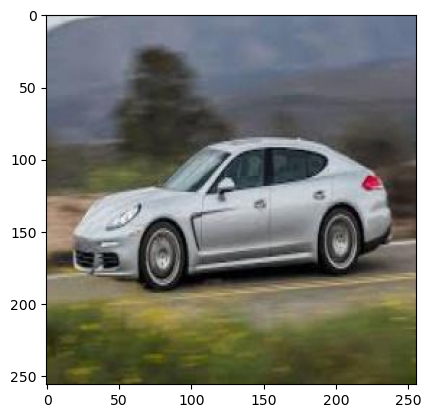

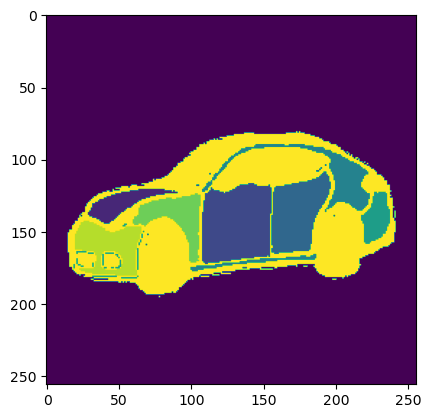

(256, 256, 4) 255
[0, 10, 20, 30, 40, 50, 70, 80, 90]


In [89]:
# Read and analyse and describe the .npy files
npy_file = np.load('./carseg_data/arrays/photo_0001.npy')

plt.imshow(npy_file[:,:,0:3])
plt.show()
plt.imshow(npy_file[:,:,3])
plt.show()
print(npy_file.shape, npy_file.max())

unique_color_labels = set()
[unique_color_labels.add(x) for x in npy_file[:,:,3].flatten()]

print(sorted(unique_color_labels)) # this corresponds to the 9 classes/segments described in the readme

In [90]:
# Check that all .npy files have the same shape and structure
unique_shapes = set()
for file in os.listdir(ARRAYS_FOLDER):
    filename = os.fsdecode(file)
    image = np.load(ARRAYS_FOLDER + filename)
    unique_shapes.add(image.shape)
    
print("Numpy files unique shapes: " + str(unique_shapes))

Numpy files unique shapes: {(256, 256, 4)}


In [91]:
#Add the numpy files
# Initialize dictionaries to store arrays for different categories
folder_path = ARRAYS_FOLDER
npy_files = [f for f in os.listdir(folder_path) if f.endswith('.npy')]
black_5_doors_arrays = {}
orange_3_doors_arrays = {}
photo_arrays = {}

# Categorize the arrays based on the file names
for file in npy_files:
    file_path = os.path.join(folder_path, file)
    
    # Load the numpy array
    array = np.load(file_path)
    
    # Extract the image data and target values
    image_data = array[:, :, :3]  # First 3 channels are the image data
    target = array[:, :, 3]  # Fourth channel contains target values
    
    if file.startswith('black_5_doors'):
        black_5_doors_arrays[file] = {'image_data': image_data, 'target': target}
       
    elif file.startswith('orange_3_doors'):
        orange_3_doors_arrays[file] = {'image_data': image_data, 'target': target}
    elif file.startswith('photo_'):
        photo_arrays[file] = {'image_data': image_data, 'target': target}
        
        
image_data_list = []
target_list = []

# Loop through the list of dictionaries and extract image_data
for data_dict in black_5_doors_arrays:
    image_data = black_5_doors_arrays[data_dict]['image_data']
    target_data = black_5_doors_arrays[data_dict]['target']
    image_data_list.append(image_data)
    target_list.append(target_data)
for data_dict in orange_3_doors_arrays:
    image_data = orange_3_doors_arrays[data_dict]['image_data']
    target_data = orange_3_doors_arrays[data_dict]['target']
    image_data_list.append(image_data)
    target_list.append(target_data)
for data_dict in photo_arrays:
    image_data = photo_arrays[data_dict]['image_data']
    target_data = photo_arrays[data_dict]['target']
    image_data_list.append(image_data)
    target_list.append(target_data)

In [93]:
# Split the data into train-test-validation
# I think that we only need the npy files
X = np.array(image_data_list)
y = np.array(target_list)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (2402, 256, 256, 3)
y_train shape: (2402, 256, 256)
X_val shape: (300, 256, 256, 3)
y_val shape: (300, 256, 256)
X_test shape: (301, 256, 256, 3)
y_test shape: (301, 256, 256)


In [106]:
input_shape=(256, 256, 3)
# Define the U-Net model
def unet_model(input_shape):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Middle
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)

    # Decoder
    up4 = UpSampling2D((2, 2))(conv3)
    concat4 = concatenate([conv2, up4], axis=-1)
    conv4 = Conv2D(64, 3, activation='relu', padding='same')(concat4)

    up5 = UpSampling2D((2, 2))(conv4)
    concat5 = concatenate([conv1, up5], axis=-1)
    conv5 = Conv2D(32, 3, activation='relu', padding='same')(concat5)

    # Output layer
    output = Conv2D(1, 1, activation='sigmoid')(conv5)

    model = Model(inputs=inputs, outputs=output)
    return model

# Create the U-Net model
model = unet_model(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])  # Use appropriate loss function for your task

# Display the model summary
model.summary()


Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_144 (Conv2D)            (None, 256, 256, 32  896         ['input_17[0][0]']               
                                )                                                                 
                                                                                                  
 max_pooling2d_31 (MaxPooling2D  (None, 128, 128, 32  0          ['conv2d_144[0][0]']             
 )                              )                                                          

In [107]:
epochs = 10  # Adjust the number of epochs based on your dataset and model convergence
batch_size = 16  # Adjust the batch size based on your available memory


def schedule(epoch, lr):
    if epoch < 5:
        return 0.01
    else:
        return 0.01 * tf.math.exp(0.1 * (5 - epoch))

lr_scheduler = LearningRateScheduler(schedule)

history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[lr_scheduler]
)

evaluation = model.evaluate(X_test, y_test)
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])


Epoch 1/5
  3/151 [..............................] - ETA: 7:14 - loss: 1254.5498 - accuracy: 0.2398

KeyboardInterrupt: 

In [ ]:
model.save('trained_model.h5')



1/1 [==============================] - 0s 107ms/step


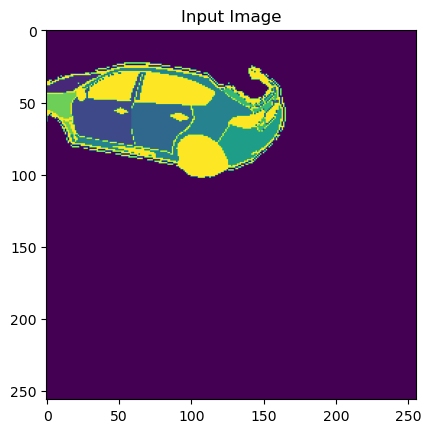

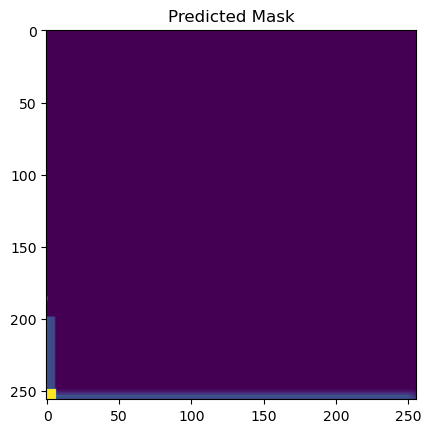

In [19]:
# Run the output on the test set

In [20]:
# Try pretrained models: MobileNetV2, ResNet101